In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import normalize_data
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 12)

# Load and Prepare Dataset

In [2]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

# Load Data
X = pd.read_pickle(f'data/x_secret_test1.pkl')
y = pd.read_pickle(f'data/y_secret_test1.pkl')

# Limit y columns
y_cols = y.columns
x_cols = ['BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE', 'ECCENTRICITY',
       'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'MEAN_MOTION', 'SUNSPOTS_1D',
       'SUNSPOTS_3D', 'SUNSPOTS_7D', 'AIR_MONTH_AVG_TEMP',
       'WATER_MONTH_AVG_TEMP', 'year', 'month_sin', 'month_cos', 'hour_sin',
       'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos',
       'ms_sin', 'ms_cos', 'year_y', 'month_sin_y', 'month_cos_y',
       'hour_sin_y', 'hour_cos_y', 'minute_sin_y', 'minute_cos_y',
       'second_sin_y', 'second_cos_y', 'ms_sin_y', 'ms_cos_y',
       'epoch_day_diff', 'epoch_sec_diff', 'epoch_ms_diff']

# Load Models and Make Predictions

In [3]:
from dataset_nm import Dataset, to_device

def predict_model(model, X, y, device='cpu'):
    pyt_device = torch.device(device)

    batch_size = 2000
    predictDataset = Dataset(X, y)
    predictLoader = torch.utils.data.DataLoader(dataset=predictDataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=5,
                                              pin_memory=True
                                             )
    num_elements = len(predictLoader.dataset)
    num_outputs = len(y.columns)
    num_batches = len(predictLoader)
    predictions = torch.zeros(num_elements, num_outputs)
    for i, (inputs, _) in tqdm(enumerate(predictLoader), total=num_batches):
        inputs = to_device(inputs, pyt_device)
        start = i*batch_size
        end = start + batch_size
        if i == num_batches - 1:
            end = num_elements
        pred = model(inputs)
        predictions[start:end] = pred.detach().cpu()
    nn_results = predictions.numpy()

    return nn_results

def load_model(name,device,path='models'):
    print(f"{path}/{name}.pth")
    cp = torch.load(f"{path}/{name}.pth",map_location=torch.device('cpu'))
    return cp['net']


def predict(model_name, X, y, device="cpu"):
    pred_data = {}
    y_dummy=pd.DataFrame(np.zeros(len(X)))

    pred_data = predict_model(load_model(model_name, device), X, y, device=device)

    y_pred = pd.DataFrame(pred_data, columns=y.columns)
    return y_pred

try:
    y_pred = pd.read_pickle('data/y_secret_test1_pred.pkl')
except:
    y_pred = predict('full_local_10_e157', X[x_cols], y)
    y_pred.to_pickle('data/y_secret_test1_pred.pkl')

In [4]:
# def denormalize_predictions(indf):
#     indf = normalize_data.normalize_all_columns(indf.copy(), reverse=True)
#     indf.columns = ['INCLINATION', 'ECCENTRICITY', 'MEAN_MOTION','RA_OF_ASC_NODE', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY','BSTAR']
#     return indf

# y_pred_dn = denormalize_predictions(y_pred)
# y_dn = denormalize_predictions(y)
# y_cols_dn = list(y_dn.columns)

# Compare Ground Truth to Predicted

In [5]:
# Show norads with least and most TLEs
ordered_norads = X.groupby('NORAD_CAT_ID')['INCLINATION'].count().sort_values().reset_index().to_numpy()
print(ordered_norads[[-5,-4,-3,-2,-1]])

for pair in ordered_norads:
    if pair[1]>100:
        print(pair)
        break

[[12212 15847]
 [ 7087 15939]
 [17128 15968]
 [12559 16071]
 [12175 16270]]
[32515   101]


In [6]:
X.head()

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION,SUNSPOTS_1D,SUNSPOTS_3D,SUNSPOTS_7D,AIR_MONTH_AVG_TEMP,WATER_MONTH_AVG_TEMP,year,month_sin,month_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,ms_sin,ms_cos,year_y,month_sin_y,month_cos_y,hour_sin_y,hour_cos_y,minute_sin_y,minute_cos_y,second_sin_y,second_cos_y,ms_sin_y,ms_cos_y,EPOCH,EPOCH_y,NORAD_CAT_ID,epoch_day_diff,epoch_sec_diff,epoch_ms_diff
0,0.0001,0.553527222222,0.436046666667,0.0246320,0.215754722222,0.786470000000,0.238438150857,0.222,0.202000000000,0.152285714286,0.683,0.598,0.258064516129,0.866025403784,0.500000000000,1.000000000000,6.123233995737e-17,0.809016994375,-0.587785252292,-0.406736643076,-0.913545457643,-0.242452936393,-0.970163168562,0.548387096774,-0.500000000000,0.866025403784,-0.866025403784,0.500000000000,0.207911690818,-0.978147600734,0.994521895368,-0.104528463268,0.469372933665,-0.883000027827,1998-03-13 06:21:34.538976,2007-12-18 20:28:16.422240,21338,-0.312516422878,0.412013888889,0.116736
1,0.0001,0.553497777778,0.693722777778,0.0245800,0.193455833333,0.808687222222,0.239097770286,0.024,0.041333333333,0.068571428571,0.514,0.422,0.548387096774,-0.500000000000,0.866025403784,-0.866025403784,5.000000000000e-01,0.207911690818,-0.978147600734,0.994521895368,-0.104528463268,0.469372933665,-0.883000027827,0.451612903226,0.500000000000,0.866025403784,-0.500000000000,0.866025403784,0.809016994375,0.587785252292,0.500000000000,0.866025403784,0.774848730799,0.632146695301,2007-12-18 20:28:16.422240,2004-02-08 22:09:05.141087,21338,0.123324866427,0.929988425926,0.281153
2,0.0001,0.553060000000,0.017540555556,0.0241076,0.669146111111,0.329485833333,0.238985800000,0.146,0.147333333333,0.179142857143,0.730,0.749,0.451612903226,0.500000000000,0.866025403784,-0.500000000000,8.660254037844e-01,0.809016994375,0.587785252292,0.500000000000,0.866025403784,0.774848730799,0.632146695301,0.645161290323,0.000000000000,1.000000000000,-0.866025403784,-0.500000000000,0.994521895368,0.104528463268,0.743144825477,0.669130606359,-0.271017113702,0.962574529104,2004-02-08 22:09:05.141087,2010-01-14 16:14:08.956320,21338,-0.189804677236,0.246481481481,0.184767
3,0.0001,0.552972777778,0.664126944444,0.0244664,0.091970555556,0.909399444444,0.239136587429,0.052,0.061333333333,0.051714285714,0.820,0.720,0.645161290323,0.000000000000,1.000000000000,-0.866025403784,-5.000000000000e-01,0.994521895368,0.104528463268,0.743144825477,0.669130606359,-0.271017113702,0.962574529104,0.419354838710,0.500000000000,-0.866025403784,0.000000000000,1.000000000000,0.866025403784,-0.500000000000,0.743144825477,0.669130606359,-0.839554634825,0.543275266456,2010-01-14 16:14:08.956320,2003-06-14 00:20:08.841408,21338,0.210738372602,0.662500000000,0.114912
4,0.0001,0.552880000000,0.397176944444,0.0247336,0.285470833333,0.716763055556,0.238946048000,0.248,0.298000000000,0.320000000000,0.495,0.455,0.419354838710,0.500000000000,-0.866025403784,0.000000000000,1.000000000000e+00,0.866025403784,-0.500000000000,0.743144825477,0.669130606359,-0.839554634825,0.543275266456,0.580645161290,0.866025403784,-0.500000000000,-0.965925826289,0.258819045103,0.913545457643,-0.406736643076,0.913545457643,0.406736643076,-0.578803056857,-0.815467363770,2003-06-14 00:20:08.841408,2008-05-14 19:19:11.598240,21338,-0.157396864325,0.208993055556,0.243168


In [7]:
def plot_norad_test_outputs(norad,ref,y,y_pred,y_cols,subtext='',kind='line',**kwargs):
    if kind == 'scatter':
        fig = plot_norad_test_outputs_scatter(norad,ref,y,y_pred,y_cols,subtext,**kwargs)
        return fig
        
    mask = ref.NORAD_CAT_ID == norad
    n = len(y_cols)

    fig, axs = plt.subplots(n,2,figsize=(17,n*2.5))

    y_test_norad = y[mask].copy()
    y_test_norad['EPOCH'] = ref[mask]['EPOCH_y']
    y_test_norad = y_test_norad.sort_values(by='EPOCH')
    y_test_norad.set_index('EPOCH')[y_cols].plot(subplots=True, ax=axs[:,0], xlabel='',kind=kind, **kwargs)

    y_pred_norad = y_pred[mask].copy()
    y_pred_norad['EPOCH'] = ref[mask]['EPOCH_y']
    y_pred_norad = y_pred_norad.sort_values(by='EPOCH')
    y_pred_norad.set_index('EPOCH')[y_cols].plot(subplots=True, ax=axs[:,1], xlabel='',kind=kind, **kwargs)

    axs[0,0].set_title(f'Ground truth for {norad} - {len(y_test_norad)} TLEs\n{subtext}')
    axs[0,1].set_title(f'Predicted for {norad} - {len(y_test_norad)} TLEs\n{subtext}')
    return fig

def plot_norad_test_outputs_scatter(norad,ref,y,y_pred,y_cols,subtext='',**kwargs):
    mask = ref.NORAD_CAT_ID == norad
    n = len(y_cols)

    fig, axs = plt.subplots(n,2,figsize=(17,n*2.5))

    y_test_norad = y[mask].copy()
    y_test_norad['EPOCH'] = ref[mask]['EPOCH_y']
    y_test_norad = y_test_norad.sort_values(by='EPOCH')
    for i,col in enumerate(y_cols):
        y_test_norad.plot.scatter(x='EPOCH',y=col,ax=axs[i,0],xlabel='',label=col,**kwargs)

    y_pred_norad = y_pred[mask].copy()
    y_pred_norad['EPOCH'] = ref[mask]['EPOCH_y']
    y_pred_norad = y_pred_norad.sort_values(by='EPOCH')
    for i,col in enumerate(y_cols):
        y_pred_norad.plot.scatter(x='EPOCH',y=col,ax=axs[i,1],xlabel='',label=col,**kwargs)

    axs[0,0].set_title(f'Ground truth for {norad} - {len(y_test_norad)} TLEs\n{subtext}')
    axs[0,1].set_title(f'Predicted for {norad} - {len(y_test_norad)} TLEs\n{subtext}')
    return fig

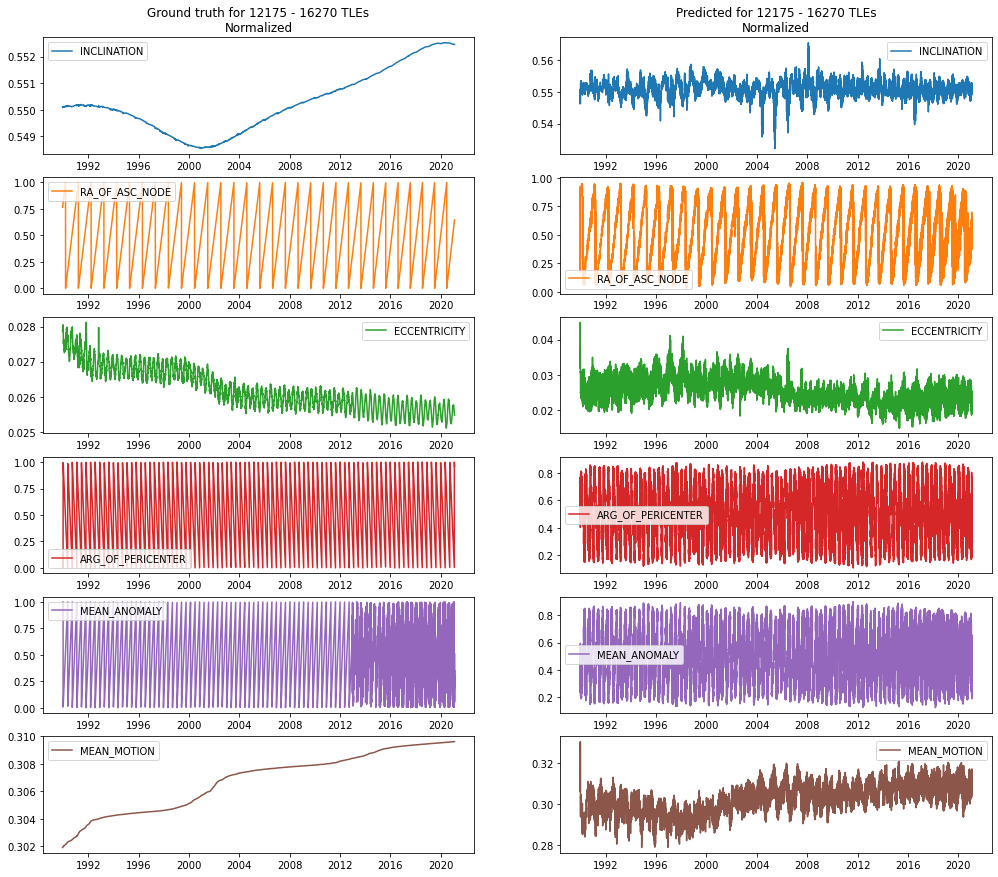

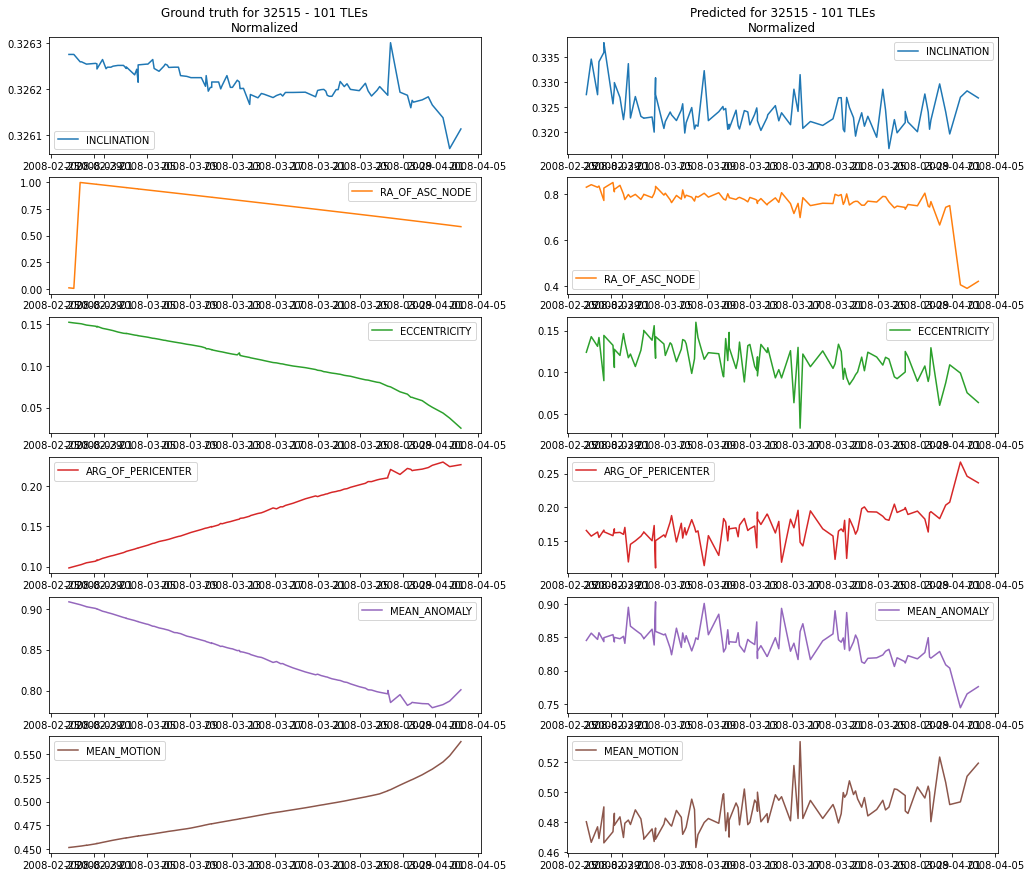

In [8]:
fig = plot_norad_test_outputs(12175,X,y,y_pred,y_cols,'Normalized')
plt.show()

fig = plot_norad_test_outputs(32515,X,y,y_pred,y_cols,'Normalized')
plt.show()

### Zoomed into 1 year

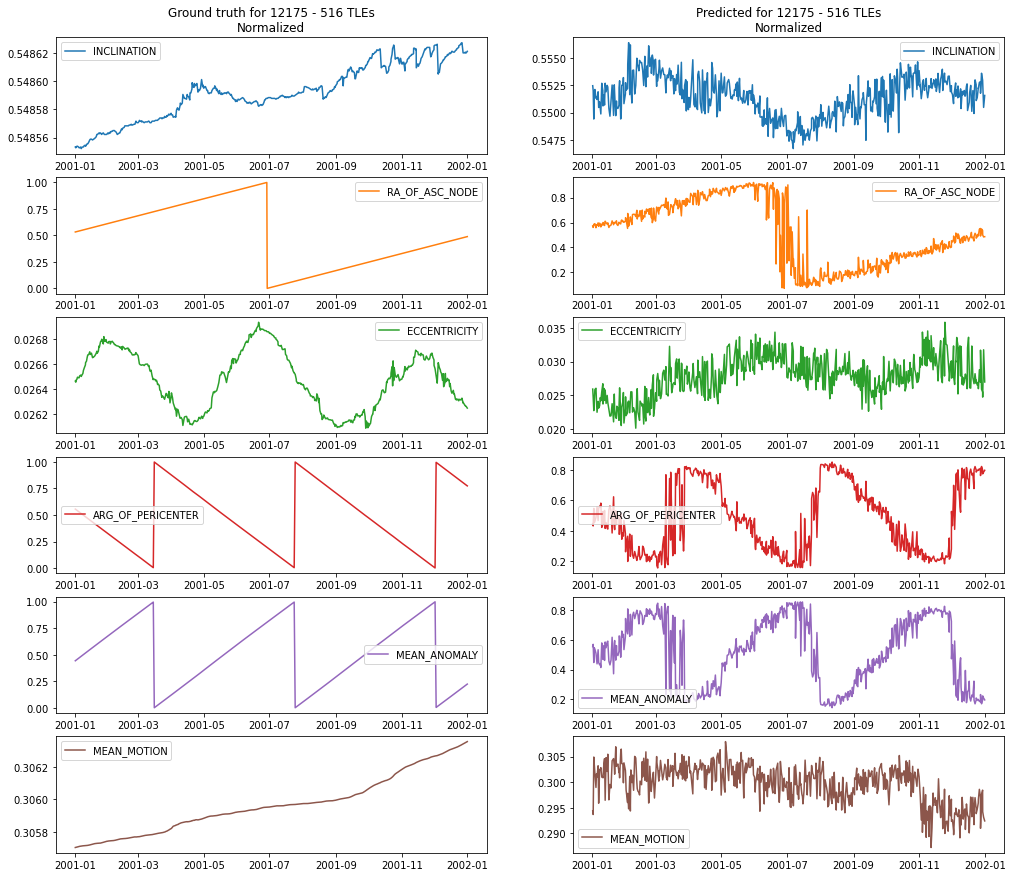

In [9]:
period_y2001_mask = X.EPOCH_y.between(pd.Timestamp(2001,1,1),pd.Timestamp(2002,1,1))
X_y2001 = X[period_y2001_mask]
y_y2001 = y[period_y2001_mask]
y_pred_y2001 = y_pred[period_y2001_mask]
fig = plot_norad_test_outputs(12175,X_y2001,y_y2001,y_pred_y2001,y_cols,'Normalized')
plt.show()

### Zoomed into 30 days

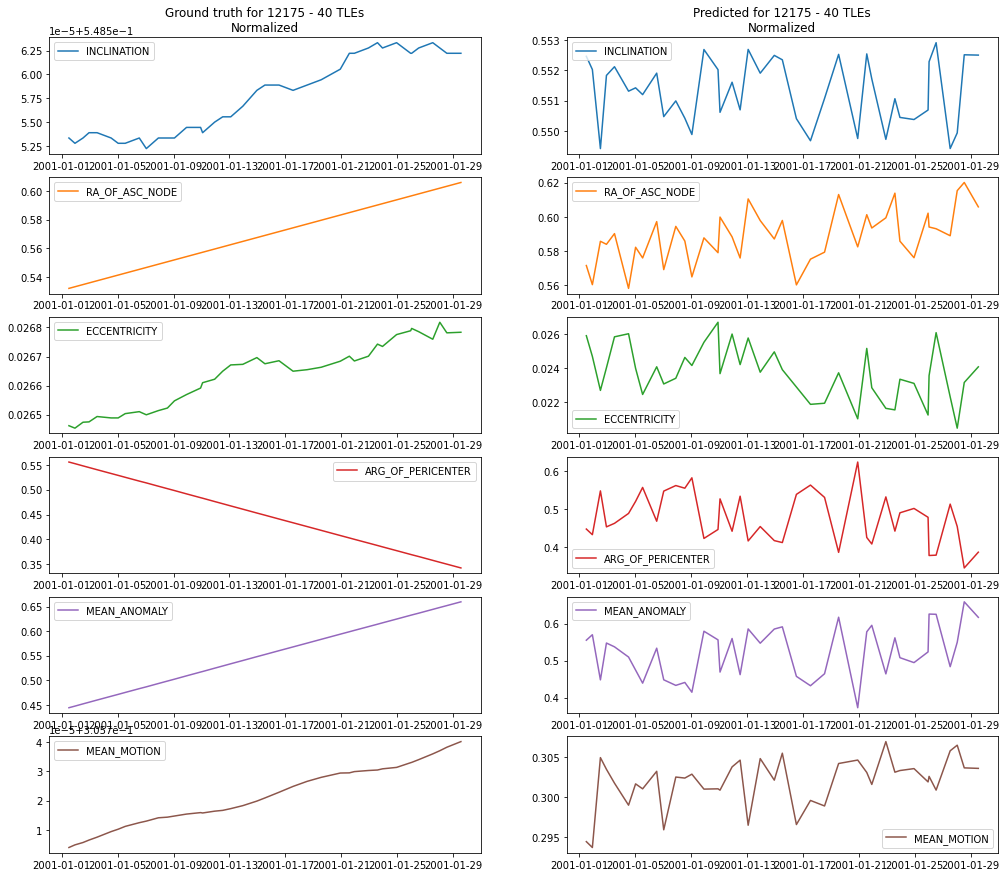

In [10]:
period_30d_mask = X.EPOCH_y.between(pd.Timestamp(2001,1,1),pd.Timestamp(2001,1,30))
#ref_30d = ref[period_30d_mask]
X_30d = X[period_30d_mask]
y_30d = y[period_30d_mask]
y_pred_30d = y_pred[period_30d_mask].copy()
fig = plot_norad_test_outputs(12175,X_30d,y_30d,y_pred_30d,y_cols,'Normalized',kind='line')
plt.show()

### Compare Predictions to their X inputs

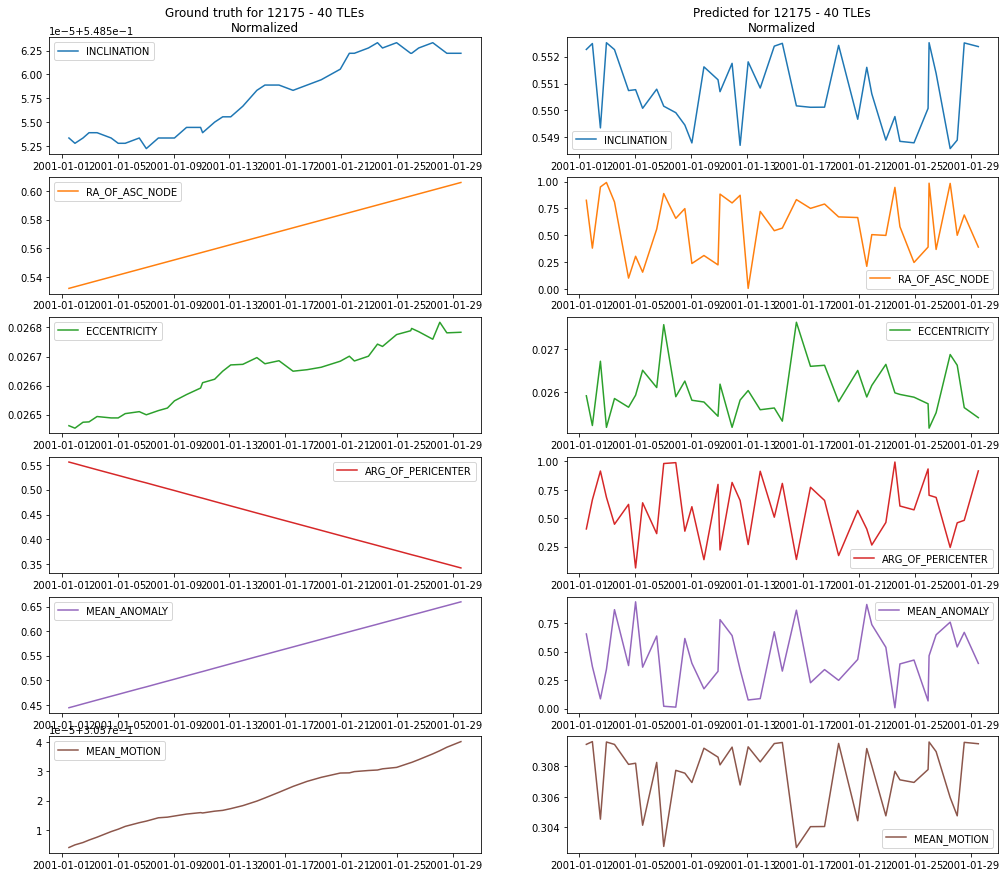

In [11]:
y_pred_X30d = y_pred_30d.copy()
y_pred_X30d[y_cols] = X_30d[y_cols]
fig = plot_norad_test_outputs(12175,X_30d,y_30d,y_pred_X30d,y_cols,'Normalized',kind='line')
plt.show()

### Compare the errors between Prediction and X

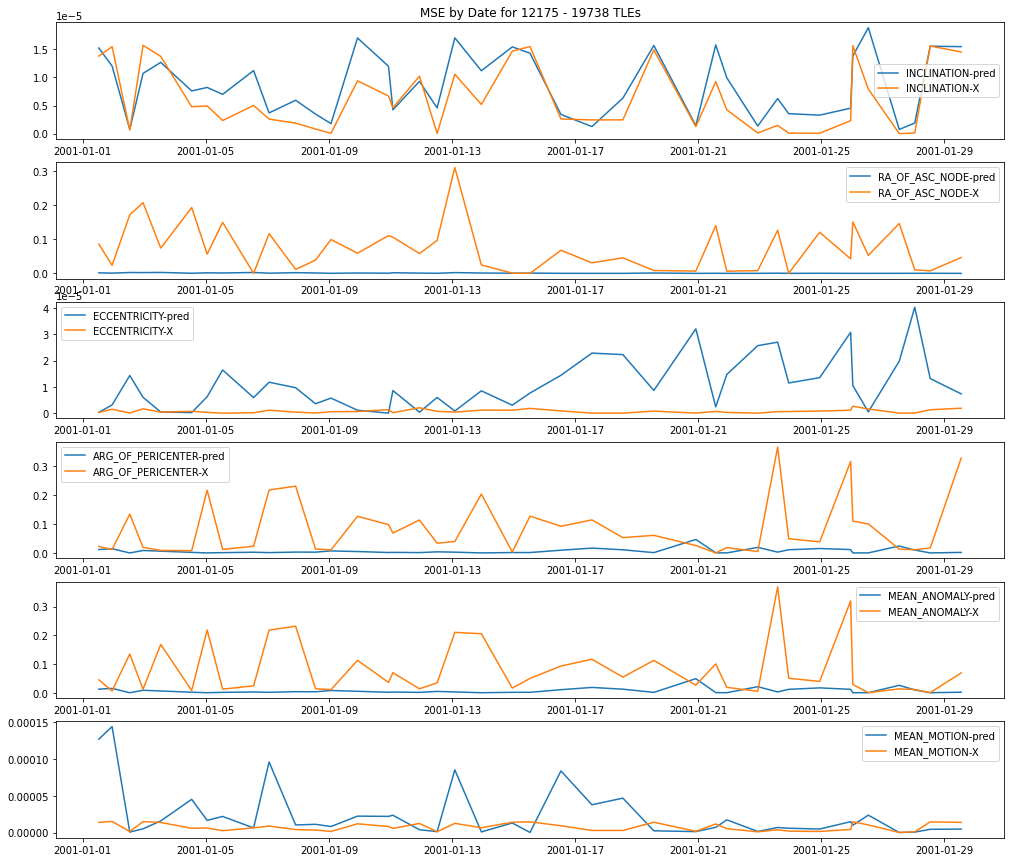

In [12]:
def get_mse(norad,ref,y,y_pred,y_cols):
    mask = ref.NORAD_CAT_ID == norad
    n = len(y_cols)
    y_se = ((y-y_pred)**2)[mask].copy()
    y_se['EPOCH'] = ref[mask]['EPOCH_y']
    y_se = y_se.set_index('EPOCH')
    y_mse = (y_se.groupby(level=0).sum() / y_se.groupby(level=0).count())
    return y_mse
    
def plot_mse(norad,ref,y,y_pred,y_pred_X,y_cols):
    n = len(y_cols)
    fig, axs = plt.subplots(n,1,figsize=(17,n*2.5))

    y_mse = get_mse(norad,ref,y,y_pred,y_cols).reset_index()
    y_mseX = get_mse(norad,ref,y,y_pred_X,y_cols).reset_index()
    
    for i,col in enumerate(y_cols):
        axs[i].plot(y_mse['EPOCH'],y_mse[col],label=f'{col}-pred')
        axs[i].plot(y_mseX['EPOCH'],y_mseX[col],label=f'{col}-X')
        axs[i].legend()
        
    axs[0].set_title(f'MSE by Date for {norad} - {len(y_pred)} TLEs')
    return fig

fig = plot_mse(12175,X_30d,y_30d,y_pred_30d,y_pred_X30d,y_cols)
plt.show()

### Comparison if data is denomarlized

In [13]:
# # These are in sample test:
# fig = plot_norad_test_outputs(12701,ref,y_dn,y_pred_dn,list(y_cols_dn),'Denormalized')
# plt.show()

# fig = plot_norad_test_outputs(38539,ref,y_dn,y_pred_dn,list(y_cols_dn),'Denormalized')
# plt.show()

# Predict For Gaps

In [14]:
def __jday_convert(x):
    '''
    Algorithm from python-sgp4:

    from sgp4.functions import jday
    jday(x.year, x.month, x.day, x.hour, x.minute, x.second + x.microsecond * 1e-6)
    '''
    jd = (367.0 * x.year
         - 7 * (x.year + ((x.month + 9) // 12.0)) * 0.25 // 1.0
           + 275 * x.month / 9.0 // 1.0
           + x.day
         + 1721013.5)
    fr = (x.second + (x.microsecond * 1e-6) + x.minute * 60.0 + x.hour * 3600.0) / 86400.0;
    return jd, fr

def find_gaps(ref, norad, days):
    # Find gaps of 100 days or more
    diff = ref[ref.NORAD_CAT_ID == norad].EPOCH_y.diff(-1)
    diff = diff[diff < -pd.Timedelta(f'{days}d')]
    diff = list(zip(diff.index,diff.index+1))
    dt_pairs = [ref.loc[list(idxs)] for idxs in diff]
    return dt_pairs

def predict_gaps(ref, X, dt_pairs):
    y_gaps = []

    for j, dt_pair in enumerate(dt_pairs):
        # Create a list of epochs to predict
        buffer = pd.Timedelta('1d')  # buffer before and after known TLE
        dt_range = pd.date_range(dt_pair.EPOCH.iloc[0] + buffer, dt_pair.EPOCH.iloc[1] - buffer, freq='1d')

        # Create the ref dataframe for the gap
        ref_gap = dt_pair.iloc[[0]].append([dt_pair.iloc[0]]*(len(dt_range)-1), ignore_index=True)
        ref_gap['EPOCH_y'] = dt_range

        # Create the X dataframe for the gap
        X_gap = X.iloc[[dt_pair.index[0]]].append([X.iloc[dt_pair.index[0]]]*(len(dt_range)-1), ignore_index=True)

        # Preform prediction on X
        y_gap = predict(X_gap, y_cols)

        # Add the epoch
        y_gap['EPOCH'] = ref_gap['EPOCH_y']
        
        # Add the gap to the list
        y_gaps.append(y_gap)
        
    return y_gaps

def plot_gaps(norad, y_gaps, y, y_cols):
    # Setup the Figure
    mask = ref.NORAD_CAT_ID == norad
    n = len(y_cols)
    y_known = y[mask].copy()
    y_known['EPOCH'] = ref[mask]['EPOCH_y']
    y_known_s = y_known.sort_values(by='EPOCH')
    fig, axs = plt.subplots(n,1,figsize=(10,n*2))
    fig.tight_layout(pad=2.0)

    # Add known data to Figure
    for i, col in enumerate(y_cols):
        axs[i].plot(y_known_s.EPOCH, y_known_s[col], label='Known')

    for j, y_gap in enumerate(y_gaps):
        for i, col in enumerate(y_cols):
            label_pred = 'Predicted' if j==0 else None
            label_gap = 'Gap' if j==0 else None

            axs[i].plot(y_gap.EPOCH, y_gap[col], color='orange', label=label_pred)
            axs[i].set_title(col)
            bottom=min(min(c[col]) for c in [y_known_s,y_gap])
            height=max(max(c[col]) for c in [y_known_s,y_gap])-bottom
            width = max(y_gap.EPOCH)-min(y_gap.EPOCH)
            axs[i].add_patch(Rectangle((min(y_gap.EPOCH),bottom), width, height, color='yellow',alpha=0.2, label=label_gap))
            axs[i].legend()
    return fig
    
    
# Find the gaps in the TLE data for a NORAD

# norad = 38539
# gap_size_in_days=100

# dt_pairs = find_gaps(ref, norad=norad, days=gap_size_in_days)
# y_gaps = predict_gaps(ref, X, dt_pairs)
# fig = plot_gaps(norad, y_gaps, y, y_cols)
# plt.show()

# Visualizing the Mean Squared Error

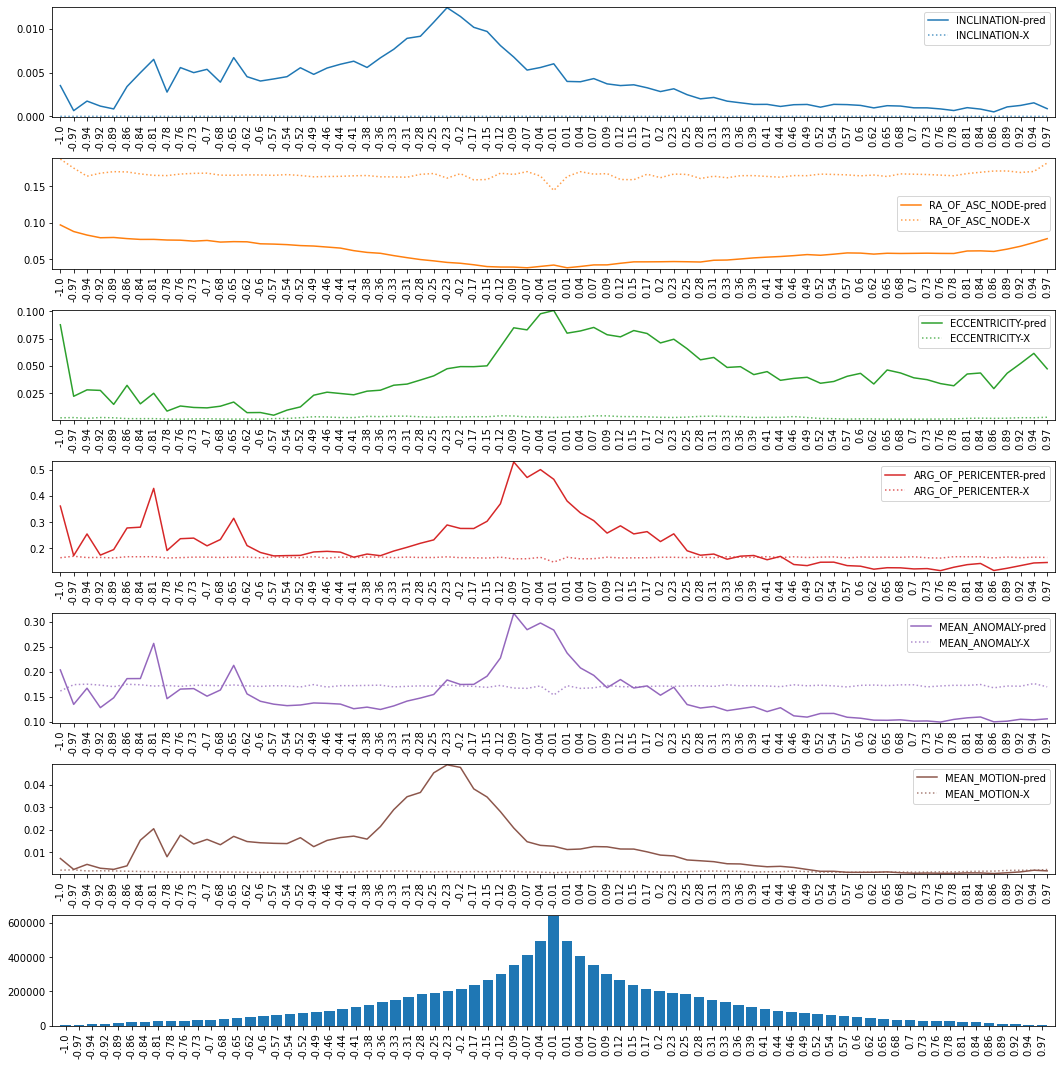

In [16]:
def plot_mse_by_epoch_diff_vs_x():
    bins=75
    n = len(y_cols)
    colors1=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink']
    colors2=['blue','orange','green','red','purple','brown','pink']
    fig, axs = plt.subplots(n+1,1,figsize=(15,n*2.5))
    fig.tight_layout(pad=2.0)
    
    y_pred_X = y_pred.copy()
    y_pred_X[y_cols] = X[y_cols]

    epoch_delta_count, bins = pd.cut(X.epoch_day_diff, bins=bins, labels=range(bins), retbins=True)
    epoch_delta_count = epoch_delta_count.reset_index()
    epoch_delta_count['X_labels']=epoch_delta_count['epoch_day_diff'].map({i:b for i,b in enumerate(bins)})
    xticks=[round(v, 2)for v in sorted(epoch_delta_count['X_labels'].unique())]
    by_count = epoch_delta_count.groupby('epoch_day_diff').count()['index']
    axs[0].bar(by_count.index, by_count)

    y_pred_se = (y-y_pred)**2
    y_pred_se['epoch_day_diff'] = epoch_delta_count['epoch_day_diff']
    y_pred_se.set_index('epoch_day_diff', inplace=True)
    y_pred_mse = (y_pred_se.groupby(level=0).sum() / y_pred_se.groupby(level=0).count())
    for i,col in enumerate(y_cols):
        axs[i+1].plot(y_pred_mse.index,y_pred_mse[col],color=colors1[i],label=f'{col}-pred')
    
    y_pred_se = (y-y_pred_X)**2
    y_pred_se['epoch_day_diff'] = epoch_delta_count['epoch_day_diff']
    y_pred_se.set_index('epoch_day_diff', inplace=True)
    y_pred_mse = (y_pred_se.groupby(level=0).sum() / y_pred_se.groupby(level=0).count())
    for i,col in enumerate(y_cols):
        axs[i+1].plot(y_pred_mse.index,y_pred_mse[col],':',color=colors1[i], alpha=0.75,label=f'{col}-X')
        axs[i+1].legend()
        
    for i in range(n+1):
        axs[i].margins(0.008)
        axs[i].set_xticks(sorted(epoch_delta_count['epoch_day_diff'].unique()))
        axs[i].set_xticklabels(xticks, rotation=90)
    
    return fig

fig = plot_mse_by_epoch_diff_vs_x()
plt.show()